In [268]:
import sys
from math import cos, pi, sin, sqrt

import numpy as np
import sympy as sym
from matplotlib import pyplot as plt
from sympy.utilities import lambdify

location = "/home/gsalinas/GitHub/MyTransport/PyTransport" # This should be the location of the PyTransport folder folder
sys.path.append(location) # Sets up python path to give access to PyTransSetup

import PyTransSetup

PyTransSetup.pathSet()  # This adds the other paths that PyTransport uses to the python path

import PyTransAngular as PyT
import PyTransScripts as PyS

In [269]:
nF = 2  # number of fields
nP = 3  # number of parameters
f = sym.symarray('f',nF)   # an array representing the nF fields present for this model
p = sym.symarray('p',nP)   # an array representing the nP parameters needed to define this model, format [alpha, R]

V = p[0]/2 * p[2]**2 * (f[0]**2 + p[1]*f[1]**2)   # this is the potential written in sympy notation
G = 6 * p[0] / (1-f[0]**2-f[1]**2)**2 * sym.Matrix([[1, 0], [0, 1]]) # this is the field metric written in sympy notation

In [270]:
nF=PyT.nF()
nP=PyT.nP()

pval = np.array([1/600, 9, 2e-5]) # Parameter values, format [alpha, R, mphi]
r0, theta0 = 0.99, pi/4
fields = r0 * np.array([cos(theta0), sin(theta0)]) # Initial values of the fields [phi, chi]

In [271]:
V = PyT.V(fields, pval) # Calculate potential from some initial conditions
dV = PyT.dV(fields, pval) # Calculate derivatives of potential

phidot0 = np.zeros(2) # set initial conditions to be in slow roll
initial = np.concatenate((fields, phidot0)) # Sets an array containing field values and there derivative in cosmic time 

In [272]:
Nstart, Nend = 0., 100
Nrange = np.linspace(Nstart, Nend, 100_000_000)

tols = np.array([10**-30, 10**-30])
back = PyT.backEvolve(Nrange, initial, pval, tols, True)

18324618


In [273]:
Ns, phis, phidots =  back.T[0], back.T[1:nF+1], back.T[nF+1:]

In [274]:
Nend = Ns[-1]
print(f'Number of e-folds: {Nend:.3}')

Number of e-folds: 91.6


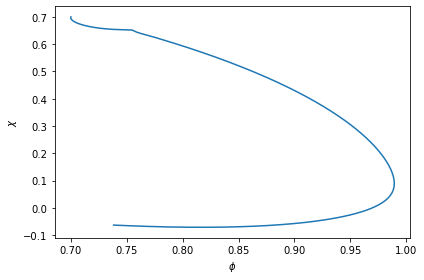

In [275]:
plt.plot(phis[0], phis[1])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\chi$')
plt.tight_layout()

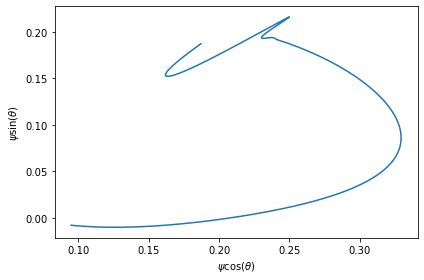

In [276]:
rs = np.sqrt(phis[0]**2 + phis[1]**2)
psis = sqrt(6*pval[0]) * np.arctanh(rs)
thetas = np.arctan(phis[1]/phis[0])
plt.plot(psis * np.cos(thetas), psis * np.sin(thetas))
plt.xlabel(r'$\psi \cos(\theta)$')
plt.ylabel(r'$\psi \sin(\theta)$')
plt.tight_layout()

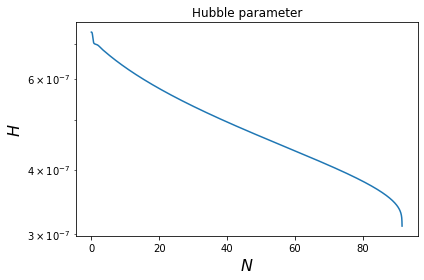

In [277]:
Hs = np.array([PyT.H(elem, pval) for elem in back[:, 1:]])
plt.plot(Ns, Hs)
plt.title('Hubble parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$H$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

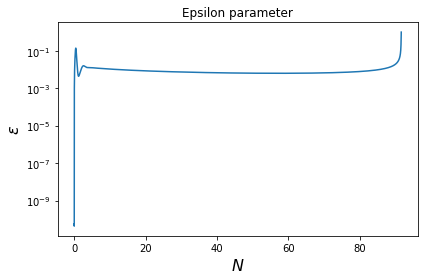

In [278]:
dN = Ns[1] - Ns[0]
epsilon = -np.gradient(Hs, dN)/Hs
plt.plot(Ns, epsilon)
plt.title('Epsilon parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

In [279]:
def dot_G(G_lbd, v1, v2, phi):
    return np.matmul(v1, np.matmul(G_lbd(phi[0], phi[1]), v2))

def mag_G(G_lbd, v, phi):
    return np.sqrt(dot_G(G_lbd, v, v, phi))

def e_pll(G_lbd, phi, phidot):
    return phidot / mag_G(G_lbd, phidot, phi)

def e_perp(G_lbd, phi, phidot):
    epll = e_pll(G_lbd, phi, phidot)
    e_perp_not_norm = np.array([epll[1], -epll[0]])
    return e_perp_not_norm / mag_G(G_lbd, e_perp_not_norm, phi)

In [280]:
G_lbd = lambdify(['f_0', 'f_1'], G.subs('p_0', pval[0]))

eplls = np.array([e_pll(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])
eperps = np.array([e_perp(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])

/tmp/ipykernel_293168/2888876044.py:8: RuntimeWarning: invalid value encountered in true_divide
  return phidot / mag_G(G_lbd, phidot, phi)


In [281]:
NExit = Nend - 55
k = PyS.kexitN(NExit, back, pval, PyT) 

print(f'Horizon exit at N = {NExit:.3} with k = {k:.3}')

/home/gsalinas/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:509: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


Horizon exit at N = 36.6 with k = 4.07e+09


In [282]:
NB = 8.0
Nstart, backExitMinus = PyS.ICsBE(NB, k, back, pval, PyT) # find conditions for NB e-folds before horizon crossing of k mode

print(f"2-pt calculation starts at: {Nstart:.3} e-folds")

2-pt calculation starts at: 28.6 e-folds


In [283]:
Nsig = Ns[Ns > Nstart]

# run the sigma routine to calc and plot the evolution of power spectrum value for this k -- can be
# repeated to build up the spectrum, here we run twice to get an crude estimate for ns
twoPt = PyT.sigEvolve(Nsig, k, backExitMinus, pval, tols, True) # puts information about the two point fuction in twoPt array
Nssig = twoPt[:, 0]
Pzeta = twoPt[:, 1] # the second column is the 2pt of zeta
sigma = twoPt[:, 1+1+2*nF:] # the last 2nF* 2nF columns correspond to the evolution of the sigma matrix

In [284]:
twoPt2 = PyT.sigEvolve(Nsig, k+.1*k, backExitMinus, pval, tols, True)
Pzeta2 = twoPt2[:,1]
n_s = (np.log(Pzeta2[-1])-np.log(Pzeta[-1])) / (np.log(k+.1*k)-np.log(k)) + 4.0
print(f'n_s: {n_s:.3f}')

n_s: 0.965


/tmp/ipykernel_293168/784343698.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


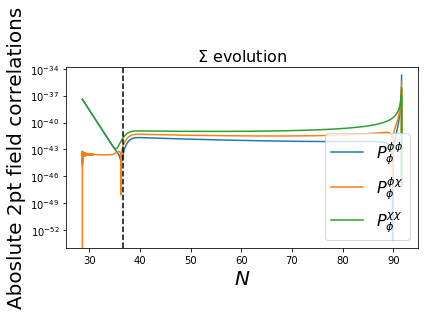

In [285]:
pairs = [(0,0), (0,1), (1,1)]
labels = ['$P^{\\phi\\phi}_\\phi$', '$P^{\\phi\\chi}_\\phi$', '$P^{\\chi\\chi}_\\phi$']
for ii, pair in enumerate(pairs):
    plt.plot(twoPt[:, 0], np.abs(sigma[:, pair[0] + 2*nF*pair[1]]), label=labels[ii])
plt.title(r'$\Sigma$ evolution',fontsize=16)
plt.legend(fontsize=16)
plt.ylabel(r'Aboslute 2pt field correlations', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.axvline(NExit, c='k', linestyle='--')
plt.tight_layout()

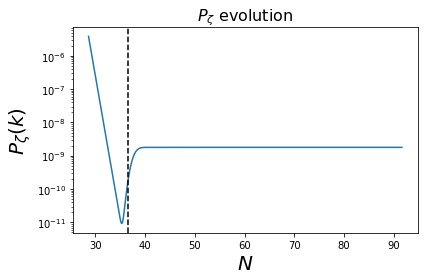

In [286]:
Pzeta_nodim = Pzeta * k**3 / 2 / np.pi**2
plt.plot(Nssig, Pzeta_nodim)
plt.axvline(NExit, c='k', linestyle='--')
plt.title(r'$P_\zeta$ evolution',fontsize=16);
plt.ylabel(r'$P_\zeta(k)$', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.tight_layout()

In [287]:
print(f'k: {k:.3}')
print(f'Power spectrum: {Pzeta_nodim[-1]:.3}')

i_exit_sig = np.argmin(np.abs(Nssig - NExit))
print(f'Power spectrum at horizon crossing: {Pzeta_nodim[i_exit_sig]:.3}')

k: 4.07e+09
Power spectrum: 1.79e-09
Power spectrum at horizon crossing: 2.05e-10


In [288]:
i_exit = np.argmin(np.abs(Ns - NExit))
phis_exit, phidots_exit = phis.T[i_exit], phidots.T[i_exit]

In [289]:
G_exit = G_lbd(phis_exit[0], phis_exit[1])
epll_exit = eplls[i_exit]
eperp_exit = eperps[i_exit]

sigma_exit = np.concatenate((sigma[i_exit_sig][0:nF], sigma[i_exit_sig][2*nF:2*nF+2])).reshape(2,2)

In [290]:
shift = len(Ns) - len(Nsig)

In [291]:
def spec(phis: np.ndarray):
    PR, CRS, PS = [], [], []
    for i in range(len(phis.T)):
        G_i = G_lbd(phis.T[i, 0], phis.T[i, 1])
        sigma_i = np.concatenate((sigma[i-shift][0:nF], sigma[i-shift][2*nF:2*nF+2])).reshape(2,2)
        PR.append(eplls[i] @ G_i @ sigma_i @ G_i @ eplls[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])
        CRS.append(eperps[i] @ G_i @ sigma_i @ G_i @ eplls[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])
        PS.append(eperps[i] @ G_i @ sigma_i @ G_i @ eperps[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])

    return np.array(PR), np.array(CRS), np.array(PS)

In [292]:
PR, CRS, PS = spec(phis)

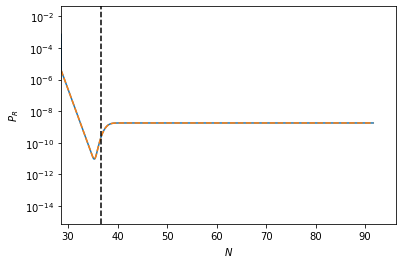

In [307]:
plt.plot(Ns, PR)
plt.plot(Nssig, Pzeta_nodim, linestyle='--')
plt.yscale('log')
plt.xlim(left=Ns[shift])
plt.xlabel(r"$N$")
plt.ylabel(r"$P_R$")
plt.axvline(NExit, c='k', linestyle='--')

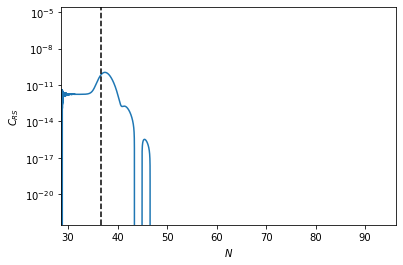

In [308]:
plt.plot(Ns, CRS)
plt.yscale('log')
plt.xlim(left=Ns[shift])
plt.xlabel(r"$N$")
plt.ylabel(r"$C_{RS}$")
plt.axvline(NExit, c='k', linestyle='--')

/tmp/ipykernel_293168/557128372.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(Ns, CRS / np.sqrt(PR * PS))


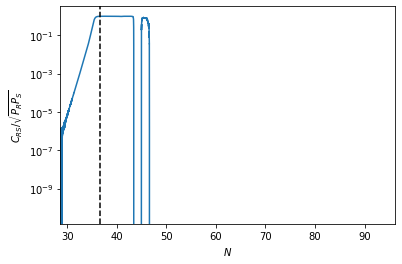

In [309]:
plt.plot(Ns, CRS / np.sqrt(PR * PS))
plt.yscale('log')
plt.xlim(left=Ns[shift])
plt.xlabel(r"$N$")
plt.ylabel(r"$C_{RS}/\sqrt{P_R P_S}$")
plt.axvline(NExit, c='k', linestyle='--')

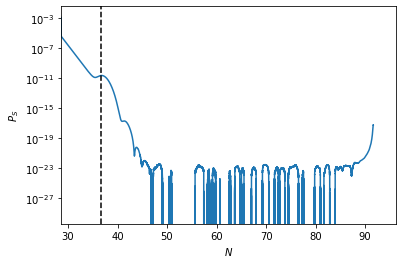

In [310]:
plt.plot(Ns, PS)
plt.yscale('log')
plt.xlim(left=Ns[shift])
plt.xlabel(r"$N$")
plt.ylabel(r"$P_S$")
plt.axvline(NExit, c='k', linestyle='--')

In [297]:
PR_exit = epll_exit @ G_exit @ sigma_exit @ G_exit @ epll_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]
CRS_exit = eperp_exit @ G_exit @ sigma_exit @ G_exit @ epll_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]
PS_exit = eperp_exit @ G_exit @ sigma_exit @ G_exit @ eperp_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]

In [298]:
CRS_exit / np.sqrt(PR_exit * PS_exit)

0.9951836906243469

In [299]:
eperp_exit @ G_exit @ sigma_exit @ G_exit @ epll_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]

6.660188099592064e-11

In [300]:
epll_exit @ G_exit @ sigma_exit @ G_exit @ eperp_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]

6.660188099592062e-11

In [301]:
eperp_exit @ G_exit @ sigma_exit @ G_exit @ eperp_exit * k**3 / 2 / np.pi**2 / 2 / epsilon[i_exit]

2.1818820757088875e-11

In [302]:
phism1, phidotsm1 = phis.T[-1], phidots.T[-1]
Gm1 = G_lbd(phism1[0], phism1[1])
epllsm1 = eplls[-1]
sigmam1 = np.concatenate((sigma[-1][0:nF], sigma[-1][2*nF:2*nF+2])).reshape(2,2)

epllsm1 @ Gm1 @ sigmam1 @ Gm1 @ epllsm1 * k**3 / 2 / np.pi**2 / 2 / epsilon[-1]

1.790228164376477e-09